# Context:
Load profile data represents "average" hourly electricity usage in KWh for segments of customers.  These segments are typically based on the customer type (e.g. Residential, Commercial, Industrial) and magnitude of usage measured by either annual usage or maximum usage at a given time.  This data is often provided by utilities and is used by Load Serving Entities (LSEs) to develop hourly estimates of customer usage when only monthly metered usage data is available.

The code in module `delmarva_load_profiles` is used to download, structure, and format this data from the utility [Delmarva Power & Light](https://en.wikipedia.org/wiki/Delmarva_Power) (DPL).

# Purpose:
Explore historical load profile data from Delmarva Power & Light in order to validate the parsing code and understand the data a little better.

# References:
* [Delmarva Class Load Profile Info](http://www.pepcoholdings.com/library/templates/interior.aspx?pageid=6442454556)

In [1]:
%matplotlib inline
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from delmarva_load_profiles import Delmarva
sns.set()

# Download Sample of Load Profile Data from Delmarva Website
Data is only made available up to two days ago.

In [2]:
dpl = Delmarva()
end_date = date.today() - pd.Timedelta(2, 'D')
start_date = end_date - pd.Timedelta(365, 'D')
print('Downloading all available Delaware and Maryland data for {:%b %d, %Y} to {:%b %d, %Y}...'
      .format(from_date, to_date))
lp = dpl.get_lp_data(start_date, end_date)
print('Download complete.')
lp.head()

,segment,date,H01,H02,H03,H04,H05,H06,H07,H08,...,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24
0,DEDGD,2017-02-04,9.78,9.56,9.36,9.30,9.41,9.78,9.77,9.23,...,9.70,9.56,9.80,10.60,11.53,11.44,11.32,11.07,10.67,10.31
1,DEDGL,2017-02-04,65.18,64.85,62.61,64.17,67.16,71.26,81.21,80.77,...,71.80,71.49,69.43,72.45,77.26,77.74,75.84,72.84,70.77,68.54
2,DEDGN,2017-02-04,1.10,1.11,1.12,1.12,1.13,1.12,1.14,1.05,...,0.98,0.96,1.01,1.09,1.18,1.18,1.18,1.19,1.20,1.17
3,DEDGP,2017-02-04,33.88,33.22,32.83,32.65,33.01,33.56,34.29,32.00,...,32.20,32.40,32.68,34.88,38.27,38.10,37.92,36.97,35.86,34.90
4,DEDGS,2017-02-04,4.49,4.40,4.33,4.31,4.35,4.50,4.50,4.24,...,4.38,4.31,4.43,4.79,5.22,5.17,5.13,5.04,4.89,4.73
5,DEDOL,2017-02-04,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.12,...,0.00,0.00,0.00,0.55,1.00,1.00,1.00,1.00,1.00,1.00
6,DEDRH,2017-02-04,2.90,2.85,2.89,2.92,2.96,3.07,3.17,3.37,...,2.58,2.64,2.79,3.01,3.19,3.26,3.26,3.18,3.08,3.02
7,DEDRS,2017-02-04,1.12,1.01,0.96,0.95,0.92,0.95,1.00,1.13,...,1.31,1.33,1.39,1.47,1.60,1.59,1.56,1.46,1.35,1.24
8,MDDGL,2017-02-04,46.51,46.23,46.36,46.78,46.70,48.39,49.47,52.64,...,57.77,57.59,59.24,59.65,60.44,59.63,60.75,53.59,48.85,48.84
9,MDDGP,2017-02-04,36.38,36.48,36.52,36.31,36.56,37.11,37.91,37.44,...,34.24,33.89,34.32,35.85,37.78,38.25,38.48,37.92,38.00,37.62


# Check Data Quality

### Check Data Types and Number of Observations

In [5]:
lp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5551 entries, 0 to 5550
Data columns (total 26 columns):
segment    5551 non-null object
date       5551 non-null datetime64[ns]
H01        5551 non-null float64
H02        5551 non-null float64
H03        5551 non-null float64
H04        5551 non-null float64
H05        5551 non-null float64
H06        5551 non-null float64
H07        5551 non-null float64
H08        5551 non-null float64
H09        5551 non-null float64
H10        5551 non-null float64
H11        5551 non-null float64
H12        5551 non-null float64
H13        5551 non-null float64
H14        5551 non-null float64
H15        5551 non-null float64
H16        5551 non-null float64
H17        5551 non-null float64
H18        5551 non-null float64
H19        5551 non-null float64
H20        5551 non-null float64
H21        5551 non-null float64
H22        5551 non-null float64
H23        5551 non-null float64
H24        5551 non-null float64
dtypes: datetime64[ns](1), fl

## Check for Duplicates

In [30]:
lp.set_index(['segment', 'date']).index.is_unique

False

In [32]:
hours = ['H{}'.format(str(h).zfill(2)) for h in range(1, 25)]
dups = lp.assign(Total=lp[hours].sum(1)).duplicated(subset=['segment', 'date', 'Total'], keep=False)
dups.sum()/2

75.0

...and remove them.

In [33]:
lp.drop_duplicates(subset=['segment', 'date'], inplace=True)
lp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5476 entries, 0 to 5550
Data columns (total 26 columns):
segment    5476 non-null object
date       5476 non-null datetime64[ns]
H01        5476 non-null float64
H02        5476 non-null float64
H03        5476 non-null float64
H04        5476 non-null float64
H05        5476 non-null float64
H06        5476 non-null float64
H07        5476 non-null float64
H08        5476 non-null float64
H09        5476 non-null float64
H10        5476 non-null float64
H11        5476 non-null float64
H12        5476 non-null float64
H13        5476 non-null float64
H14        5476 non-null float64
H15        5476 non-null float64
H16        5476 non-null float64
H17        5476 non-null float64
H18        5476 non-null float64
H19        5476 non-null float64
H20        5476 non-null float64
H21        5476 non-null float64
H22        5476 non-null float64
H23        5476 non-null float64
H24        5476 non-null float64
dtypes: datetime64[ns](1), fl

## Check for Missing Values

### Create Target Index
All dates and segments (profiles) that should have been downloaded.

In [14]:
rng = pd.date_range(start_date, end_date)
segments = lp.segment.unique()
idx = pd.MultiIndex.from_product([segments, rng], names=['segment', 'date'])

In [18]:
idx.is_unique

True

In [35]:
lp = lp.set_index(['segment', 'date']).reindex(idx)
lp.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5490 entries, (DEDGD, 2017-02-04 00:00:00) to (MDDTN, 2018-02-04 00:00:00)
Data columns (total 24 columns):
H01    5476 non-null float64
H02    5476 non-null float64
H03    5476 non-null float64
H04    5476 non-null float64
H05    5476 non-null float64
H06    5476 non-null float64
H07    5476 non-null float64
H08    5476 non-null float64
H09    5476 non-null float64
H10    5476 non-null float64
H11    5476 non-null float64
H12    5476 non-null float64
H13    5476 non-null float64
H14    5476 non-null float64
H15    5476 non-null float64
H16    5476 non-null float64
H17    5476 non-null float64
H18    5476 non-null float64
H19    5476 non-null float64
H20    5476 non-null float64
H21    5476 non-null float64
H22    5476 non-null float64
H23    5476 non-null float64
H24    5476 non-null float64
dtypes: float64(24)
memory usage: 1.0+ MB


In [36]:
idx_nulls = lp[lp.isnull().any(1)].index
lp.loc[idx_nulls].head()

,,H01,H02,H03,H04,H05,H06,H07,H08,H09,H10,...,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24
segment,date,,,,,,,,,,,,,,,,,,,,,
DEDGD,2017-06-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEDGL,2017-06-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEDGN,2017-06-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEDGP,2017-06-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEDGS,2017-06-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### (Linearly) Interpolate Missing Values by Profile

In [39]:
lp_interpolated = (lp
                   .groupby(level='segment')
                   .transform(lambda frame: frame.interpolate()))
lp_interpolated['interpolated'] = False
lp_interpolated.loc[idx_nulls, 'interpolated'] = True
lp_interpolated.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5490 entries, (DEDGD, 2017-02-04 00:00:00) to (MDDTN, 2018-02-04 00:00:00)
Data columns (total 25 columns):
H01             5490 non-null float64
H02             5490 non-null float64
H03             5490 non-null float64
H04             5490 non-null float64
H05             5490 non-null float64
H06             5490 non-null float64
H07             5490 non-null float64
H08             5490 non-null float64
H09             5490 non-null float64
H10             5490 non-null float64
H11             5490 non-null float64
H12             5490 non-null float64
H13             5490 non-null float64
H14             5490 non-null float64
H15             5490 non-null float64
H16             5490 non-null float64
H17             5490 non-null float64
H18             5490 non-null float64
H19             5490 non-null float64
H20             5490 non-null float64
H21             5490 non-null float64
H22             5490 non-null float64
H23   

In [40]:
lp_interpolated.interpolated.value_counts()

False    5476
True       14
Name: interpolated, dtype: int64

# Get a Feel for the Data
Parse out some attributes, reshape, and plot the data.

### Parsed Attributes
* **hour** : Hour of the day (1 - 24).
* **day** : Weekday name (Sunday, Monday, ..., Saturday).
* **date_label** : <i>Month day</i> formatted date.
* **state** : US state (MD or DE).
* **profile** : Two character code for specific load profile.
* **profile_name** : More descriptive name for profile from utility.
* **customer_type** : Type of customer (Residential, Commercial, Other).
* **season** : Season of the year, e.g. summer (defined as Jun 16 - Sep 15).

In [43]:
profiles = {'RS': 'Residential Service', 'RH': 'Residential Heating', 
            'GS': 'Small General Service', 'GL': 'Large General Service', 
            'GP': 'General Service, Primary', 'GT': 'General Service - Transmission', 
            'OL': 'Outdoor Lighting', 'TN': 'Telecommunication Network Service',
            'GD': 'General Service', 'GN': 'General Service - Other'}

customer_types = {'G': 'Commercial', 'R': 'Residential', 'O': 'Other',
                  'T': 'Other'}

def get_season(dt):
    """Get season of the year (winter, summer, spring, fall)."""
    d = pd.Timestamp(dt)
    yr = d.year
    dx = d.replace(year=yr-1, month=12, day=16)
    dy = d.replace(month=2, day=15)
    mo3 = pd.Timedelta(3, 'M')
    for i, season in enumerate(['winter', 'spring', 'summer', 'fall']):
        if dx <= d <= dy:
            return season
        else:
            dx += mo3
            dy += mo3
    else:
        return 'winter'

lp_tidy = (lp_interpolated
           .reset_index()
           .melt(['segment', 'date', 'interpolated'], 
                 var_name='hour', 
                 value_name='load'))
lp_tidy['hour'] = lp_tidy.hour.str.slice(start=1).astype('int')
lp_tidy['day'] = lp_tidy.date.dt.weekday_name
lp_tidy['date_label'] = lp_tidy.date.dt.strftime('%b %d')
lp_tidy['state'] = lp_tidy.segment.str.slice(stop=2)
lp_tidy['profile'] = lp_tidy.segment.str.slice(start=-2)
lp_tidy['profile_name'] = lp_tidy.profile.map(profiles)
lp_tidy['customer_type'] = lp_tidy.profile.transform(lambda x: customer_types[x[0]])
lp_tidy['season'] = lp_tidy.date.transform(get_season)

lp_tidy.head()

,segment,date,interpolated,hour,load,day,date_label,state,profile,profile_name,customer_type,season
0,DEDGD,2017-02-04,False,1,9.78,Saturday,Feb 04,DE,GD,General Service,Commercial,winter
1,DEDGD,2017-02-05,False,1,9.55,Sunday,Feb 05,DE,GD,General Service,Commercial,winter
2,DEDGD,2017-02-06,False,1,8.44,Monday,Feb 06,DE,GD,General Service,Commercial,winter
3,DEDGD,2017-02-07,False,1,7.86,Tuesday,Feb 07,DE,GD,General Service,Commercial,winter
4,DEDGD,2017-02-08,False,1,7.09,Wednesday,Feb 08,DE,GD,General Service,Commercial,winter


### Take an inventory

In [44]:
lp_tidy.groupby(['state', 'profile_name', 'customer_type']).size().unstack(1).fillna(0).astype('int')

profile_name         General Service  General Service - Other  \
state customer_type                                             
DE    Commercial                8784                     8784   
      Other                        0                        0   
      Residential                  0                        0   
MD    Commercial                   0                        0   
      Other                        0                        0   
      Residential                  0                        0   

profile_name         General Service, Primary  Large General Service  \
state customer_type                                                    
DE    Commercial                         8784                   8784   
      Other                                 0                      0   
      Residential                           0                      0   
MD    Commercial                         8784                   8784   
      Other                                 0                      0   
      Residential                           0                      0   

profile_name         Outdoor Lighting  Residential Heating  \
state customer_type                                          
DE    Commercial                    0                    0   
      Other                      8784                    0   
      Residential                   0                 8784   
MD    Commercial                    0                    0   
      Other                      8784                    0   
      Residential                   0                 8784   

profile_name         Residential Service  Small General Service  \
state customer_type                                               
DE    Commercial                       0                   8784   
      Other                            0                      0   
      Residential                   8784                      0   
MD    Commercial                       0                   8784   
      Other                            0                      0   
      Residential                   8784                      0   

profile_name         Telecommunication Network Service  
state customer_type                                     
DE    Commercial                                     0  
      Other                                          0  
      Residential                                    0  
MD    Commercial                                     0  
      Other                                       8784  
      Residential                                    0

## What Does the Distribution of Load Look Like by Hour and Season?

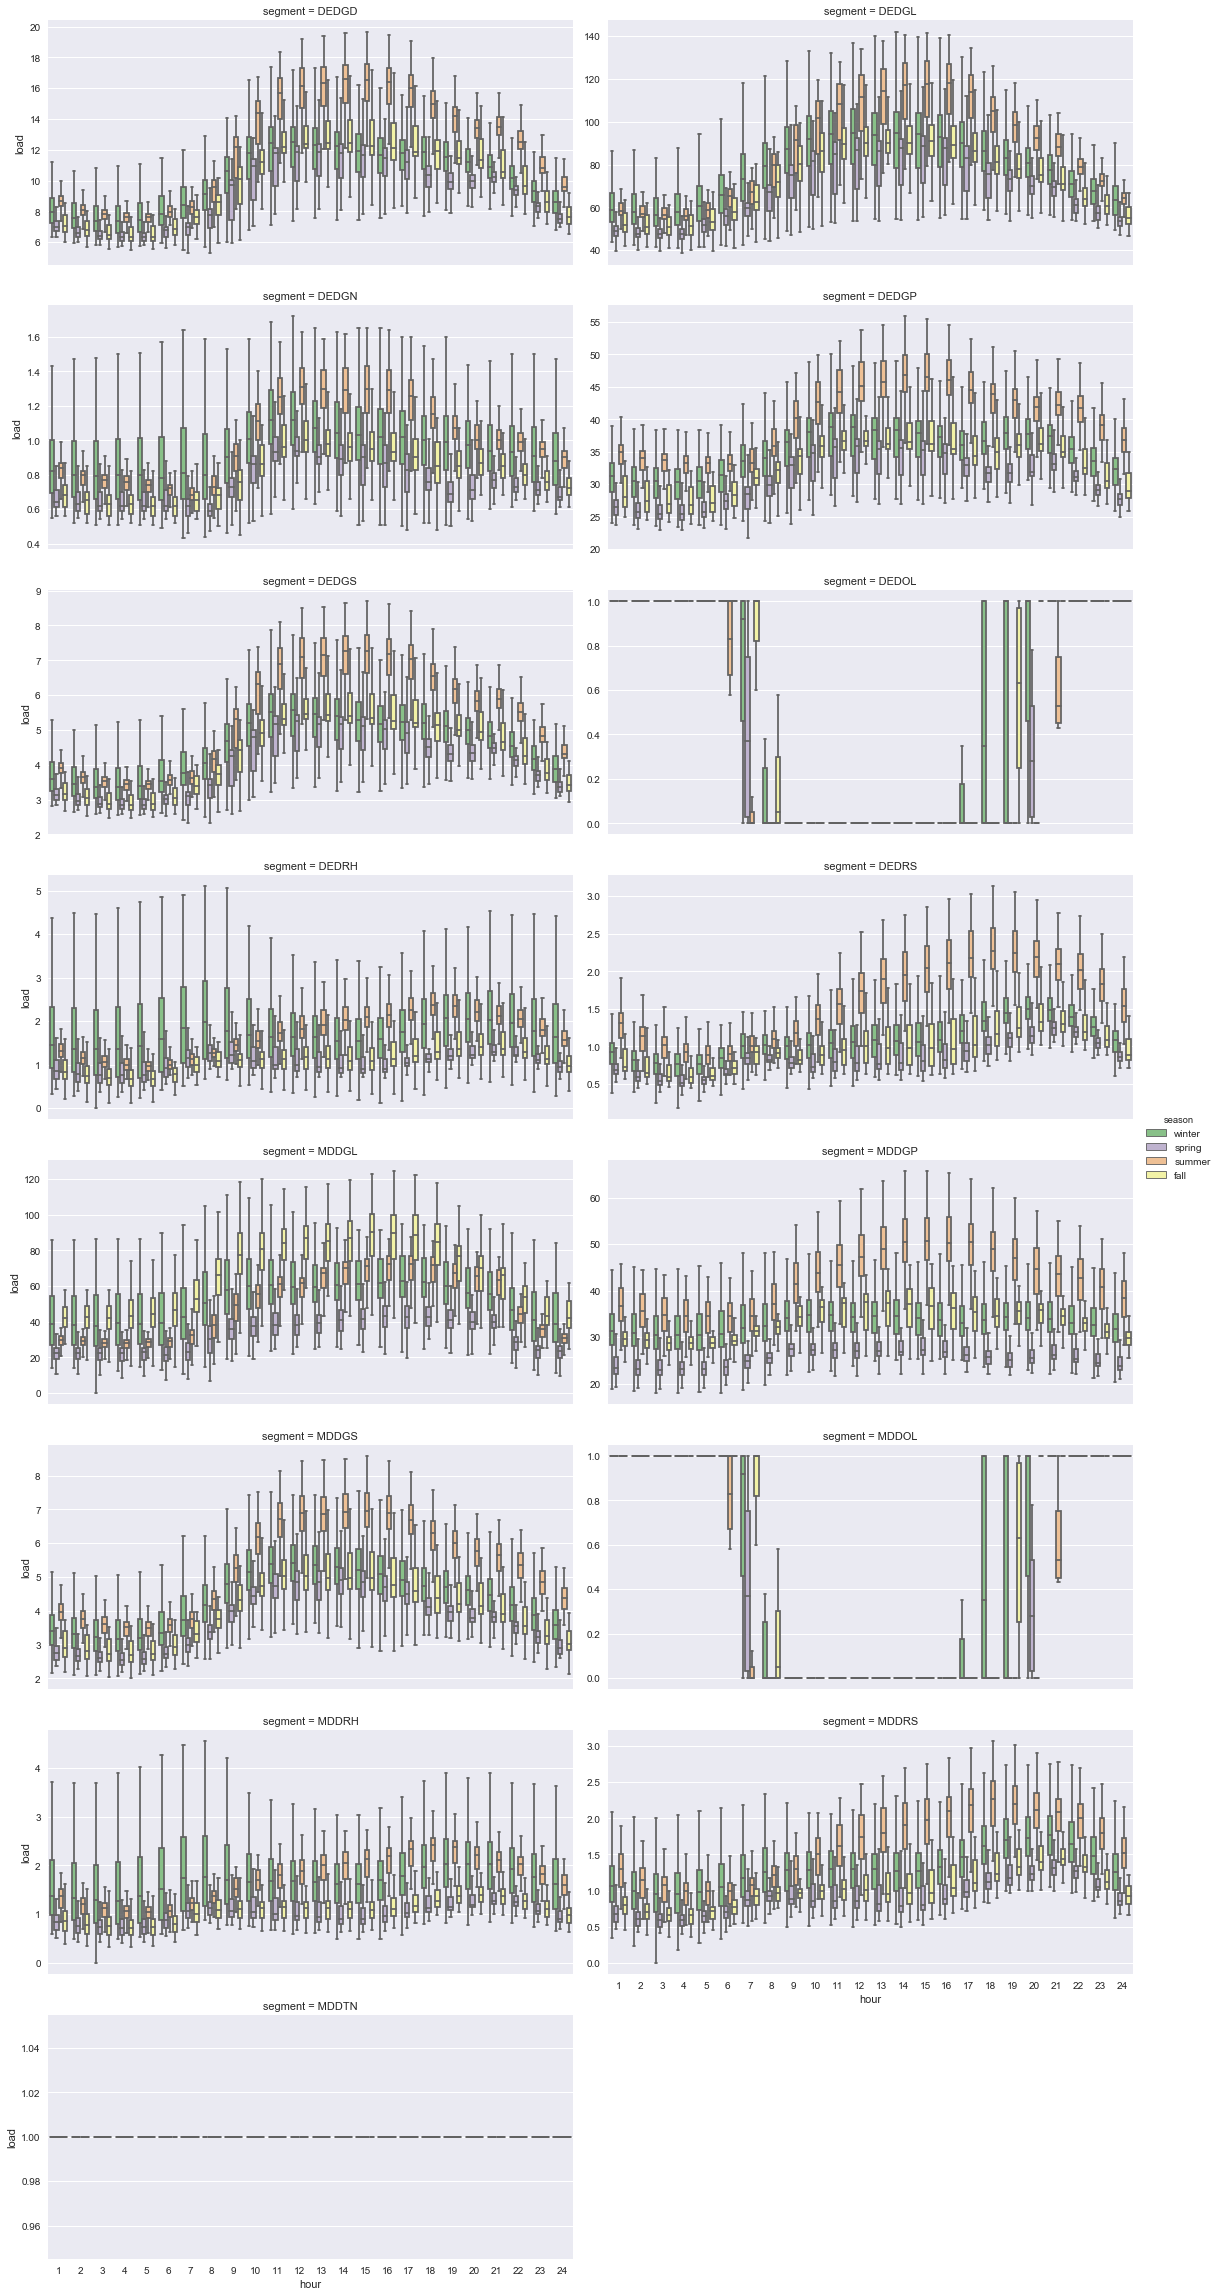

In [45]:
g = sns.factorplot(data=lp_tidy, x='hour', y='load', hue='season', kind='box',
                   col='segment', col_wrap=2, aspect=2, sharey=False,
                   palette='Accent', showfliers=False)

#### Some observations:
* Residential customers generally use the most electricity around 7 - 9 AM and 8 - 10 PM in the winter and spring.
* Spring and winter are typically in line in terms of magnitude and hourly profile, but summer usage is generally higher, especially after 10 AM.
* Residential Heating (RH) customers have less of a difference in their summer usage, but large variances in the winter usage.

## How Have the Profiles Changed Over Time?
Aggregate load by week and segment.

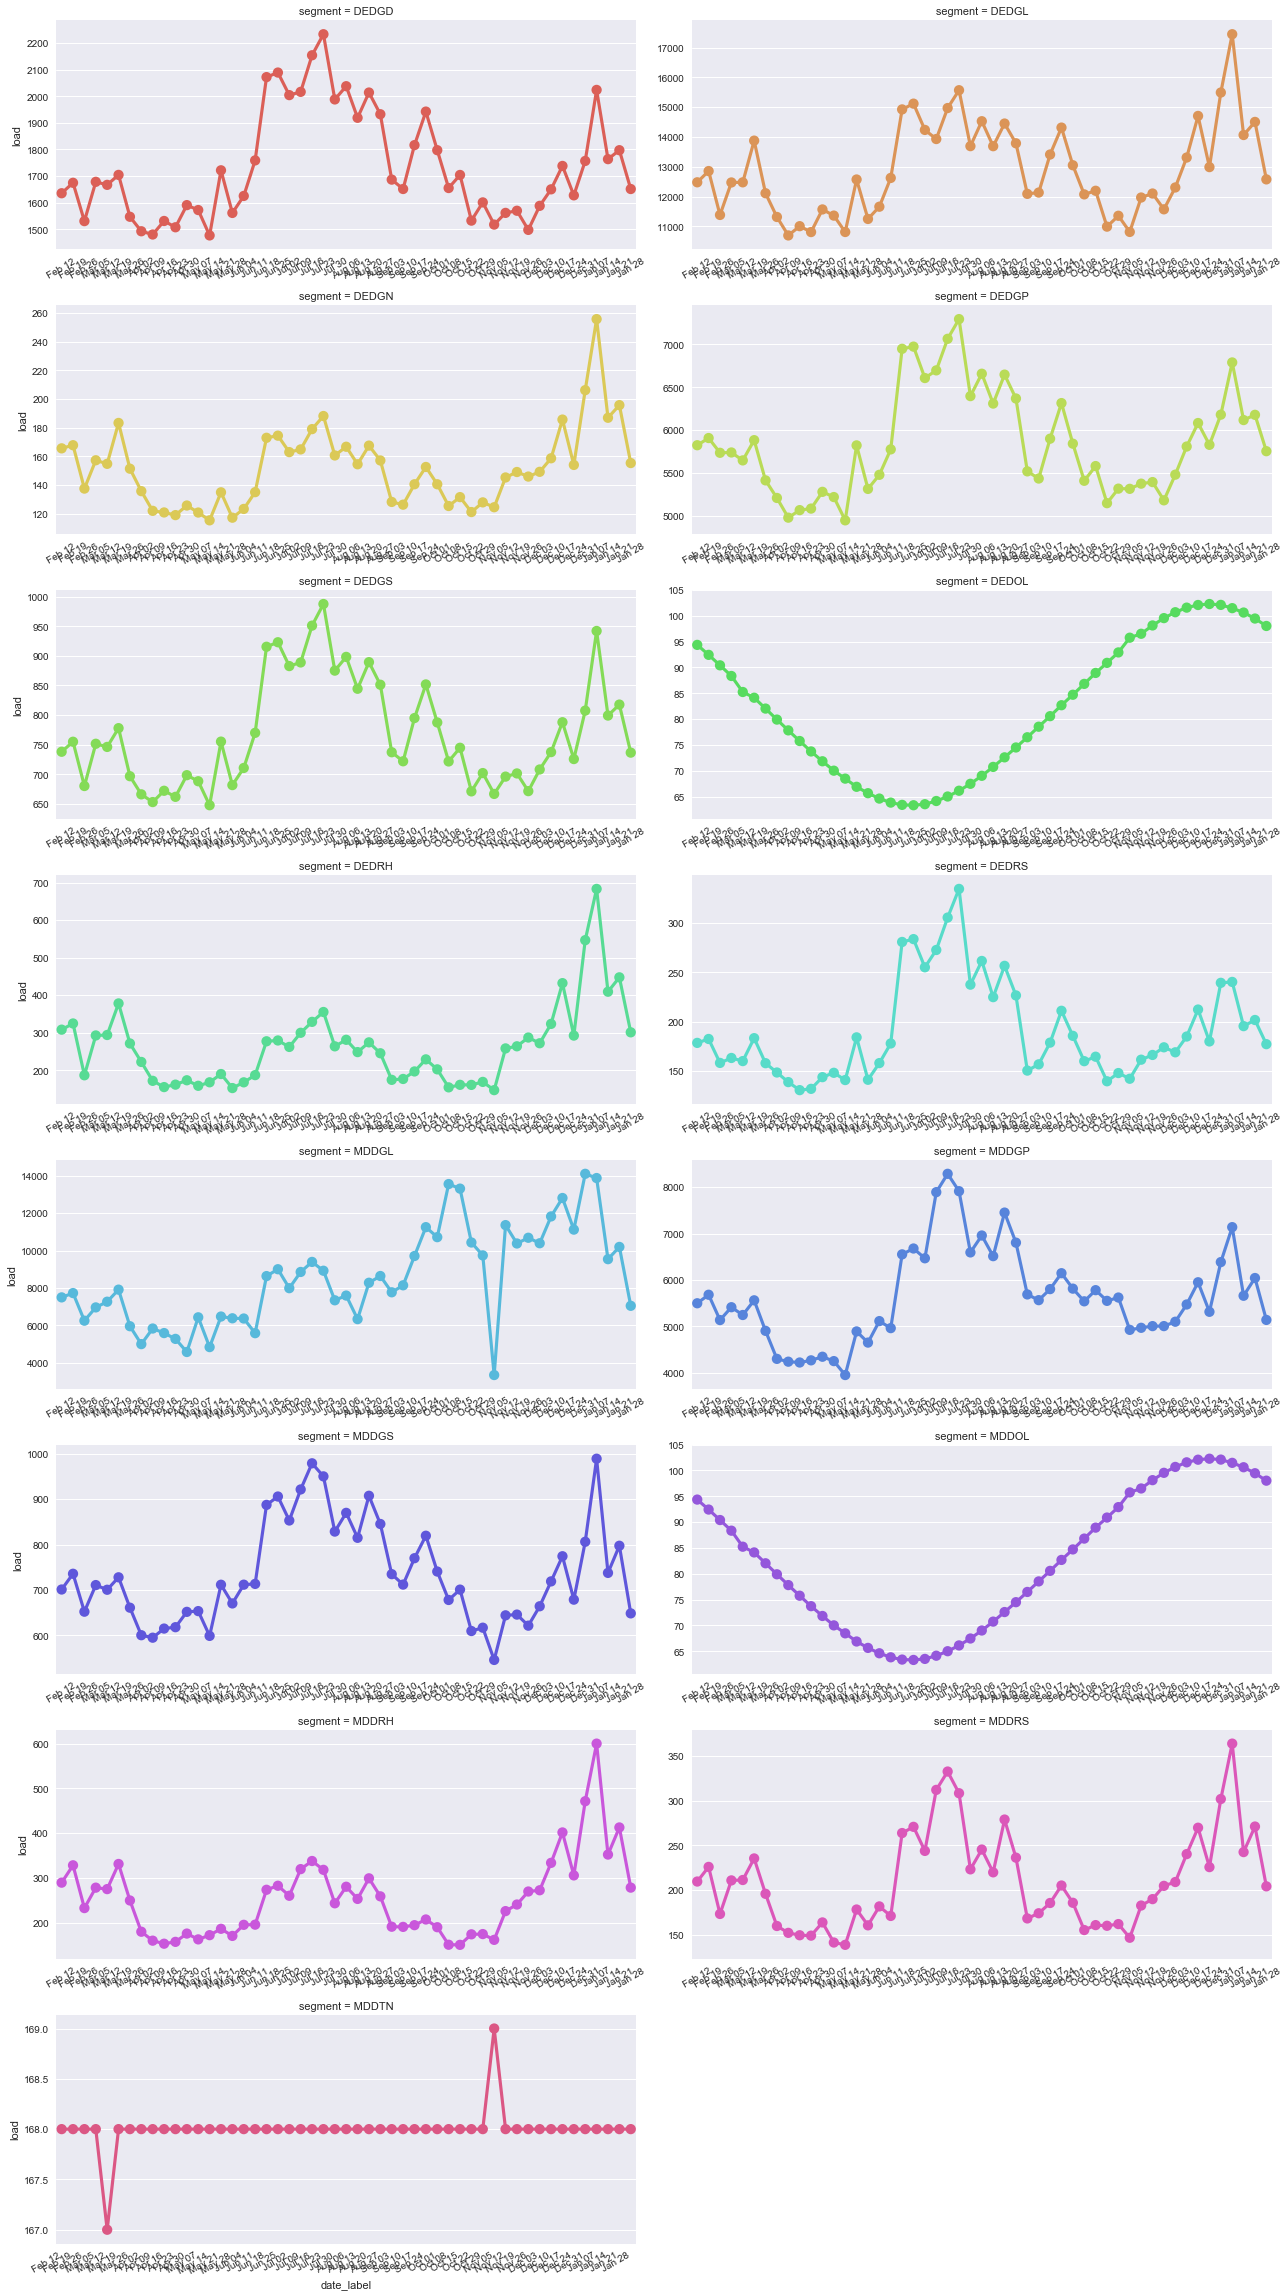

In [47]:
grouper = [pd.Grouper(freq='W'), 'segment']
data = lp_tidy.set_index('date').groupby(grouper)['load'].sum().sort_index()
core = [df.iloc[1:-1] for i, df in data.groupby(level='segment')]
data = (pd.concat(core)
        .reset_index()
        .assign(date_label=lambda df: df.date.dt.strftime('%b %d')))
g = sns.factorplot(x='date_label', y='load', hue='segment', col='segment', col_wrap=2,
                   aspect=2.25, data=data, size=4, sharey=False, kind='point', 
                   palette='hls')
g.fig.autofmt_xdate();
for ax in g.axes:
    plt.setp(ax.get_xticklabels(), visible=True, rotation=30)
plt.tight_layout();